In [12]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tqdm.auto import tqdm # For progress bars

In [13]:
# --- 1. 配置 ---
MODEL_NAME = "IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment"
# !!! 请确保文件路径正确 !!!
DATA_PATH = r"D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\lm_cleaned_taptap_reviews.csv" # 使用原始字符串(r"...")处理Windows路径
TEXT_COLUMN = "review_content" # 包含评论文本的列名
LABEL_COLUMN = "sentiment"    # 包含情感标签的列名 (假设 0=负面, 1=正面)
TEST_SIZE = 0.2               # 测试集所占比例 (例如 20%)
RANDOM_STATE = 42             # 用于复现结果的随机种子
BATCH_SIZE = 32               # 每个批次处理的数据量，根据GPU显存调整
MAX_LENGTH = 512              # 输入文本的最大长度，根据模型和数据调整

In [14]:
# --- 2. GPU 设置 ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"发现并使用 GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("未发现可用 GPU, 使用 CPU")

发现并使用 GPU: NVIDIA GeForce RTX 4070 SUPER


In [15]:
# --- 3. 加载和准备数据 ---
print(f"\n正在加载数据: {DATA_PATH}...")
try:
    df = pd.read_csv(DATA_PATH)
    print(f"成功加载 {len(df)} 条数据.")

    # 基本数据检查和清理
    print(f"检查 '{TEXT_COLUMN}' 和 '{LABEL_COLUMN}' 列是否存在空值...")
    initial_rows = len(df)
    df = df.dropna(subset=[TEXT_COLUMN, LABEL_COLUMN])
    if len(df) < initial_rows:
        print(f"已删除 {initial_rows - len(df)} 行包含空值的记录.")

    # 确保标签是整数类型
    df[LABEL_COLUMN] = df[LABEL_COLUMN].astype(int)

    print("\n数据样本 (前5行):")
    print(df[[TEXT_COLUMN, LABEL_COLUMN]].head())

    print("\n标签分布:")
    print(df[LABEL_COLUMN].value_counts())

except FileNotFoundError:
    print(f"错误: 数据文件未找到，请检查路径: {DATA_PATH}")
    exit()
except KeyError as e:
    print(f"错误: CSV文件中缺少列: {e}. 请确保 '{TEXT_COLUMN}' 和 '{LABEL_COLUMN}' 列存在。")
    exit()
except Exception as e:
    print(f"加载数据时发生错误: {e}")
    exit()


正在加载数据: D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\lm_cleaned_taptap_reviews.csv...
成功加载 39985 条数据.
检查 'review_content' 和 'sentiment' 列是否存在空值...

数据样本 (前5行):
                  review_content  sentiment
0            可以体验一下，剧情不错，但可能会有点迷          1
1                           剧情很好          1
2  刺激，感受到了友情，亲情，自我，爱慕，传承，等待 ，与纯真          1
3            毋庸置疑的神作 第一次回溯时间的是葵啊          1
4                   没有别的可以说，剧情神作          1

标签分布:
sentiment
1    26353
0    13632
Name: count, dtype: int64


In [16]:
# --- 4. 划分数据集 ---
print(f"\n正在划分数据集 (测试集比例: {TEST_SIZE})...")
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df[TEXT_COLUMN].tolist(),
    df[LABEL_COLUMN].tolist(),
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df[LABEL_COLUMN].tolist() # 保持训练集和测试集中标签比例一致
)
print(f"训练集样本数: {len(train_texts)}")
print(f"测试集样本数: {len(test_texts)}")


正在划分数据集 (测试集比例: 0.2)...
训练集样本数: 31988
测试集样本数: 7997


In [17]:
# --- 5. 加载模型和分词器 ---
print(f"\n正在加载预训练模型和分词器: {MODEL_NAME}...")
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
    model.to(device) # 将模型移动到 GPU 或 CPU
    print("模型和分词器加载成功.")
except Exception as e:
    print(f"加载模型或分词器时出错: {e}")
    print("请检查模型名称是否正确，以及是否已安装 transformers 和 torch 库。")
    exit()


正在加载预训练模型和分词器: IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment...
模型和分词器加载成功.


In [18]:
# --- 6. 创建 PyTorch 数据集类 ---
class SentimentReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]) # 确保输入是字符串
        label = int(self.labels[idx]) # 确保标签是整数

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,      # 添加 [CLS] 和 [SEP]
            max_length=self.max_len,      # 设定最大长度
            return_token_type_ids=False,  # RoBERTa 不需要 segment IDs
            padding='max_length',         # 填充到最大长度
            truncation=True,              # 截断超过最大长度的文本
            return_attention_mask=True,   # 返回 attention mask
            return_tensors='pt',          # 返回 PyTorch 张量
        )

        return {
            'review_text': text, # 可以保留原始文本用于调试
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [19]:
# --- 7. 创建 DataLoader ---
# 注意：我们只需要为测试集创建 DataLoader 来进行预测评估
test_dataset = SentimentReviewDataset(test_texts, test_labels, tokenizer, MAX_LENGTH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE) # 不需要 shuffle 测试集

In [20]:
# --- 8. 定义预测函数 ---
def get_predictions(model, dataloader, device):
    model.eval()  # 将模型设置为评估模式
    predictions = []
    real_values = []

    with torch.no_grad(): # 在评估模式下不计算梯度
        progress_bar = tqdm(dataloader, desc="模型预测中")
        for batch in progress_bar:
            # 将批次数据移动到指定设备 (GPU/CPU)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # 模型前向传播
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # 获取预测结果 (概率最高的类别索引)
            preds = torch.argmax(logits, dim=1)

            # 将预测结果和真实标签从 GPU 移回 CPU 并存储
            predictions.extend(preds.cpu().numpy())
            real_values.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(real_values)

In [21]:
# --- 9. 执行预测 ---
print("\n开始在测试集上进行预测...")
y_pred, y_true = get_predictions(model, test_dataloader, device)


开始在测试集上进行预测...


模型预测中:   0%|          | 0/250 [00:00<?, ?it/s]


--- 模型评估结果 ---

分类报告 (Classification Report):
              precision    recall  f1-score   support

      负面 (0)     0.5793    0.8346    0.6839      2726
      正面 (1)     0.8892    0.6866    0.7749      5271

    accuracy                         0.7370      7997
   macro avg     0.7343    0.7606    0.7294      7997
weighted avg     0.7836    0.7370    0.7439      7997


混淆矩阵 (Confusion Matrix):
[[2275  451]
 [1652 3619]]


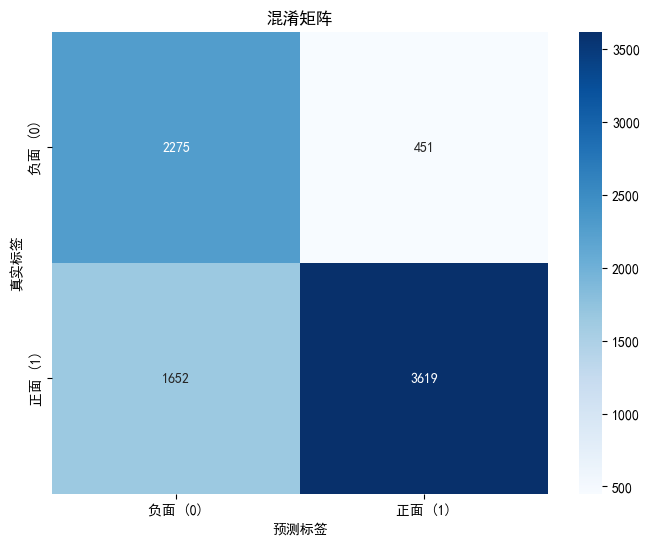


已显示混淆矩阵图。

脚本执行完毕。


In [23]:
# --- 10. 评估结果 ---
print("\n--- 模型评估结果 ---")

# 检查预测和真实标签是否为空
if len(y_pred) == 0 or len(y_true) == 0:
    print("错误: 未能生成预测结果。请检查预测流程或数据。")
elif len(np.unique(y_pred)) == 1:
     print(f"警告: 模型仅预测出一种类别: {np.unique(y_pred)[0]}")
     print("这可能表示模型性能不佳或数据存在问题。")

# 定义标签名称 (根据您的数据，0=负面, 1=正面)
# 如果您的标签有其他含义，请修改这里的名称
target_names_map = {0: '负面 (0)', 1: '正面 (1)'}
# 获取实际存在的标签，并按顺序生成报告用的标签名列表
unique_labels = sorted(np.unique(np.concatenate((y_true, y_pred))))
target_names_report = [target_names_map.get(label, f'未知标签 ({label})') for label in unique_labels]


print("\n分类报告 (Classification Report):")
# 使用 zero_division=0 防止某些类别没有预测样本时出现警告
print(classification_report(y_true, y_pred, target_names=target_names_report, digits=4, zero_division=0))

print("\n混淆矩阵 (Confusion Matrix):")
cm = confusion_matrix(y_true, y_pred, labels=unique_labels) # 确保矩阵标签顺序正确
print(cm)

# 可选：使用 seaborn 和 matplotlib 可视化混淆矩阵
try:
    import seaborn as sns
    import matplotlib.pyplot as plt
    # Matplotlib 显示中文设置（如果需要）
    plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体为黑体
    plt.rcParams['axes.unicode_minus'] = False   # 解决保存图像是负号'-'显示为方块的问题

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names_report, yticklabels=target_names_report)
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    plt.title('混淆矩阵')
    plt.show()
    print("\n已显示混淆矩阵图。")
except ImportError:
    print("\n提示: 安装 seaborn 和 matplotlib (`pip install seaborn matplotlib`) 可以可视化混淆矩阵。")
except Exception as e:
    print(f"\n绘制混淆矩阵时出错: {e}")


print("\n脚本执行完毕。")